## Preicting Song Populairty with Spotify Data
### Feb 2025

Nicholas Ballingall

Team Name: 'team name'

*NOTE: Due to the length constraint of this project, some exploratory analysis was omitted. This analysis did not directly contribute to the final model. When exporting to csv, there are 132 rows insetad of the required 114. We are unsure if these extra rows are the result of RFECV or something else. Some code readability (i.e. vertical line length) was sacrificed in an attempt to make the page limit*

### 1 – Notebook Set-Up

Each csv file is imported as a dataframe and dynamically assigned a variable name. No outside data sources could be used on this project (such as spotify's API), so rows with NaN values were dropped. Release years were inconsistent, so a decade column was added and the 'Number' column was reset to be used as a decade-specific subindex in the combined dataframe.

Non-standard characters (NSC)s were present in the data. Chardet was used to check data encodign, but did not correct the issue.

'Genre Groups' were originally assigned to help reduce the number of genre data points for analysis. Even with refinement from running Cosine Similarity, Euclidian Distance to see how simialar the contents of each genre group was, and Welch's t-test to understand their average 'pop', this new feature did prove to have any predictive power in the model. Collaborative songs were also identified based on text in the song title, but this too had little predictive power & was omitted.

In [4]:
# 1.1 – Import Libraries

# Data Processing & Analysis
import pandas as pd
import numpy as np
import re # text manipulation (regular expressions)
from itertools import combinations
import chardet # check data encoding
import scipy.stats as stats # 2T, ANOVA, etc.
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import itertools
import random
import uuid # add unique ID to different models (de-bugging)

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# ML Model 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.svm import SVR
import optuna # model tuning

In [5]:
# 1.2 – Load Data

# Set Filepath & Names
local_path = '' # add here if needed
decades = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']


# Load Data
"""
Create dataframes & dynamically assign variable names
(technically bad practice, but it makes this really easily scalable)
"""
for decade in decades:
    file_path = f'{local_path}/spotify_data/{decade}.csv'

    # Auto-detect encoding – attempt to fix text anomalies in data
    with open(file_path, 'rb') as f:
        det_enc = chardet.detect(f.read())["encoding"]

    # Read csv
    df = pd.read_csv(file_path, encoding = det_enc)
    
    # Add 'decade' column
        # for grouping in combined df & encoding
    df['decade'] = int(decade) # as integer
    df.insert(min(5, len(df.columns)), 'decade', df.pop('decade'))  # insert at position 6 (next to 'year')

    # Assign name & column to variable
    globals()[f'df_{decade}'] = df # output look like 'df_yyyy'

In [6]:
# 1.2 – Check for NaN values

def findNan(df):
    """
    Defined a function to loop through all decades more easily. Picks out & lists where
    NaN values are. ALso preserves decade-specific sub-index.
    """
    df.dropna(inplace = True) # drop NaN values
    nan_counts = df.isna().sum()  # count NaNs per column
    nan_cols = nan_counts[nan_counts > 0]  # filter columns with NaNs

    if not nan_cols.empty:
        print(f'\nNaN values in {df}:')
        print('Columns with NaN values:')
        print('\n')
        
        for col, count in nan_columns.items(): # get no. of NaNs in each column
            if count > 1:
                print(f'{col} – {count} values')
            else:
                print(f'{col} – {count} value') # minor & unnessecary but nice to have
    #else:
        #print('None found')

# Show NaN values
for decade in decades:
    df = globals()[f'df_{decade}']
    findNan(df)

In [7]:
# 1.3 – Create Combined DataFrame

# Fix number column
    # used as decade-specific index

def newNums(df, col = 'number'):
    """
    Fixes number column to be used as decad-specific index in combined dataframe
    
    Parameters:
        df – dataframe
        col – column to add (new 'number' col)

    Returns:
        df with corrected numbering
    """
    
    # Drop old number col
    if 'Number' in df.columns: # ensure column exists first
        df = df.drop(columns = ['Number'])

    # Add new col immediately after index
    df.insert(0, col, range(1, len(df) + 1))
    
    return df

# Apply function to dataframes
for decade in decades:
    df = globals()[f'df_{decade}']
    df = newNums(df)
    globals()[f'df_{decade}'] = df  # update the dataframe globally

# Create dictionary of dataframes
def decDict(decades):
    return {decade: globals()[f'df_{decade}'] for decade in decades if f'df_{decade}' in globals()}

df_dict = decDict(decades) # apply function


# Create full dataframe using dictionary
df_all = pd.concat(df_dict.values(), ignore_index = True) # reset actual index, keep decade no. col

In [8]:
# 1.4 – Find Non-Standard Characters (NSC) in Song Title & Artist

def findSyms(df):
    """
    Returns any NSCs as a list

    Parameters:df – dataframe
    Returns: list of NSCs in data
    """
    sym_cells = []
    pattern = re.compile(r'[^a-zA-Z0-9\-\(\)\,\'\"\ \&\.\/\!\?\*\:\$\#\ç\é\ñ]') # set 'safe' characters here

    for col in df.columns:
        for index, value in df[col].dropna().items():  # drop NaN just in case
            if isinstance(value, str) and pattern.search(value):  # limit to string vals
                sym_cells.append((index, col, value))

    return sym_cells

# 1.5.1 – Manually Fix Remaining NSCs
    # (accounting for file encoding on csv import didn't fix things)

# Dictionary of manual corrections
corrections = {
    'Friends (with BloodPopÂ®)': 'Friends (with BloodPop®)',
    'SeÃ±orita': 'Señorita',
    'BeyoncÃ©': 'Beyoncé',
    'DÃ©senchantÃ©e - Radio Edit': 'Désenchantée - Radio Edit',
    'Ultra NatÃ©': 'Ultra Naté',
    'CÃ©line Dion': 'Celine Dion',
    "You're The One That I Want - From â€œGreaseâ€": "You're The One That I Want", # careful with ' & "
    "Walkinâ€™ My Baby Back Home": "Walkin' My Baby Back Home"
}

"""
'Axwell /\ Ingrosso' & 'BloodPopR' are apparenlty correct
    (Keeping the above non-standard characters as they display correctly, 
    will remove if there's any future issues)
"""

def fixNSC (df, corrections = corrections):
    """
    Swaps NSC values using corrections list

    Paramters:
        df – dataframe
        corrections – list of corrections (could probs just harcode but didn't)

    Returns: corrected df
    """
    for col in df.columns:
        for index, value in df[col].dropna().items():
            if isinstance(value, str) and value in corrections:
                df.at[index, col] = corrections[value]  # Replace incorrect value with corrected one
    return df

# Apply functions
df_all = fixNSC(df_all) # make corrections
nsc = findSyms(df_all) # check corrections

# print any found nscs
for row, col, value in nsc:
    print(f'\n"{value}" – found at Column {col}, Row {row}')


"Friends (with BloodPop®)" – found at Column title, Row 612

"Axwell /\ Ingrosso" – found at Column artist, Row 630


In [9]:
# 1.5 – Find Re-Releases

def oddYears(df):
    """
    Checks years against decade & return outliers (re-releases)

    Parameters: df - dataframe
    Returns: List of rows with re-releases
    """
    rr_rows = []

    # Check for rows where year > decade
    for index, row in df.iterrows():
        if row['year'] > row['decade'] + 9:
            rr_rows.append({'index': index, 'year': row['year'], 'decade': row['decade'], 'title': row['title'], 'artist': row['artist']})

    return rr_rows

# Apply function
rr_years = oddYears(df_all)

# 2.4.1 – Mark re-releases with new column
df_all['re-release'] = np.where(df_all['year'] > df_all['decade'] + 9, 'yes', 'no')
df_all.insert(min(6, len(df_all.columns)), 're-release', df_all.pop('re-release'))

In [10]:
# 1.6 – Average Artist Popularity
df_all['artist pop'] = df_all.groupby('artist')['pop'].transform('mean').round(4)

# 1.7 – Check for duplicate rows (extra rows in Kaggle csv)
ignore_col = 'decade'

# Drop dupes
df_drop = df_all.loc[~df_all.drop(columns = [ignore_col]).duplicated()]

# Check the number of rows after cleaning
print(f'Rows before: {df_all.shape[0]}, Rows after: {df_all.shape[0]}')

Rows before: 651, Rows after: 651


### 2 – Exploratory Data Analysis

Descriptive dfs are generated by decade and artist, which appear to be the two most significant categorical features. It was also previously done by 'genre group' before omitting the feature.

Popularity distributions per decade show a shift from being right-skewed to left-skewed over time, with a particulalry aggressive skew in 2000's & 2010's data; potentially a reflection of the different listening habits of each playlist's target audience. The clearer linear relationsip formed between the average popularity of artists with >1 appearences in the data in 2010 vs. all previous data could indicate that the change in how listeners discover music and artists stay relevant is an important factor in maintaining relevancy. Their populairty doesn't seem to vary or decline as much vs. previous decades.

Both of the above-points signify that a song's release date may play a large role in predicitng popularity. Further, the 2010 data has a tigher, more linear clustering for the average popularity of artists who appear >1 times. All datasets have 'one hit wonders' artist average popularity be a direct linear relationship with their song; as is to be expected.

Feature correlation was checked, and 'viridis' was used for the heatmap visualsiation as it's easier to see negative correlations comapred to the default 'coolwarm'. Variance inflation factor (VIF) was then used to check multicolliniarity of independent numerical variables ('pop' was omitted), and select categorical variables were ran through an ANOVA test. No significant omissions could be made from this.

Skewed data was accounted for using log transformation for right-skewed data; exponential transformation for left-skewed data, but the transformed data was not used in any optmial version of the final model.

EDA has identified 9 features that are most likely to contribute to a song's popularity. They are organised into three tiers of significance:
- **Strong**: dB, live, spch, acous
- **Semi-Strong**: dnce, dur, artist pop
- **Over-Fitting**: artist pop, number

In [13]:
# 2.1 – Descriptive Stats

# By Decade
dec_stats = df_all.groupby('decade').agg(
    
    songs = ('number', 'count'),  # total no. of songs
    mean_pop = ('pop', 'mean'), # avg. pop
    median_pop = ('pop', 'median'),  # median pop
    pop_std_dev = ('pop', 'std'),  # std. dev
    min_pop = ('pop', 'min'),  # min pop
    max_pop = ('pop', 'max'),  # max pop
    pop_Q1 = ('pop', lambda x: x.quantile(0.25)),  # Q1
    pop_Q3 = ('pop', lambda x: x.quantile(0.75)),  # Q3
    top_genre = ('top genre', lambda x: x.mode()[0] if not x.mode().empty else None) # most common genre
    
).reset_index()  # reset index, keep decade col

dec_stats.columns = dec_stats.columns.str.replace('_', ' ') # gets rid of underscores (can't do so above)
dec_stats = dec_stats.round(2)  # 2 dp

# By Artist
art_stats = df_all.groupby('artist').agg(
    
    songs = ('number', 'count'),  # total no. of songs
    mean_pop = ('pop', 'mean'), # avg. pop
    median_pop = ('pop', 'median'),  # median pop
    pop_std_dev = ('pop', 'std'),  # std. dev
    min_pop = ('pop', 'min'),  # min pop
    max_pop = ('pop', 'max'),  # max pop
    pop_Q1 = ('pop', lambda x: x.quantile(0.25)),  # Q1
    pop_Q3 = ('pop', lambda x: x.quantile(0.75)),  # Q3
    top_genre = ('top genre', lambda x: x.mode()[0] if not x.mode().empty else None) # most common genre
    
).reset_index()  # reset index, keep decade col

art_stats.columns = art_stats.columns.str.replace('_', ' ')
art_stats = art_stats.round(2)  # 2 dp

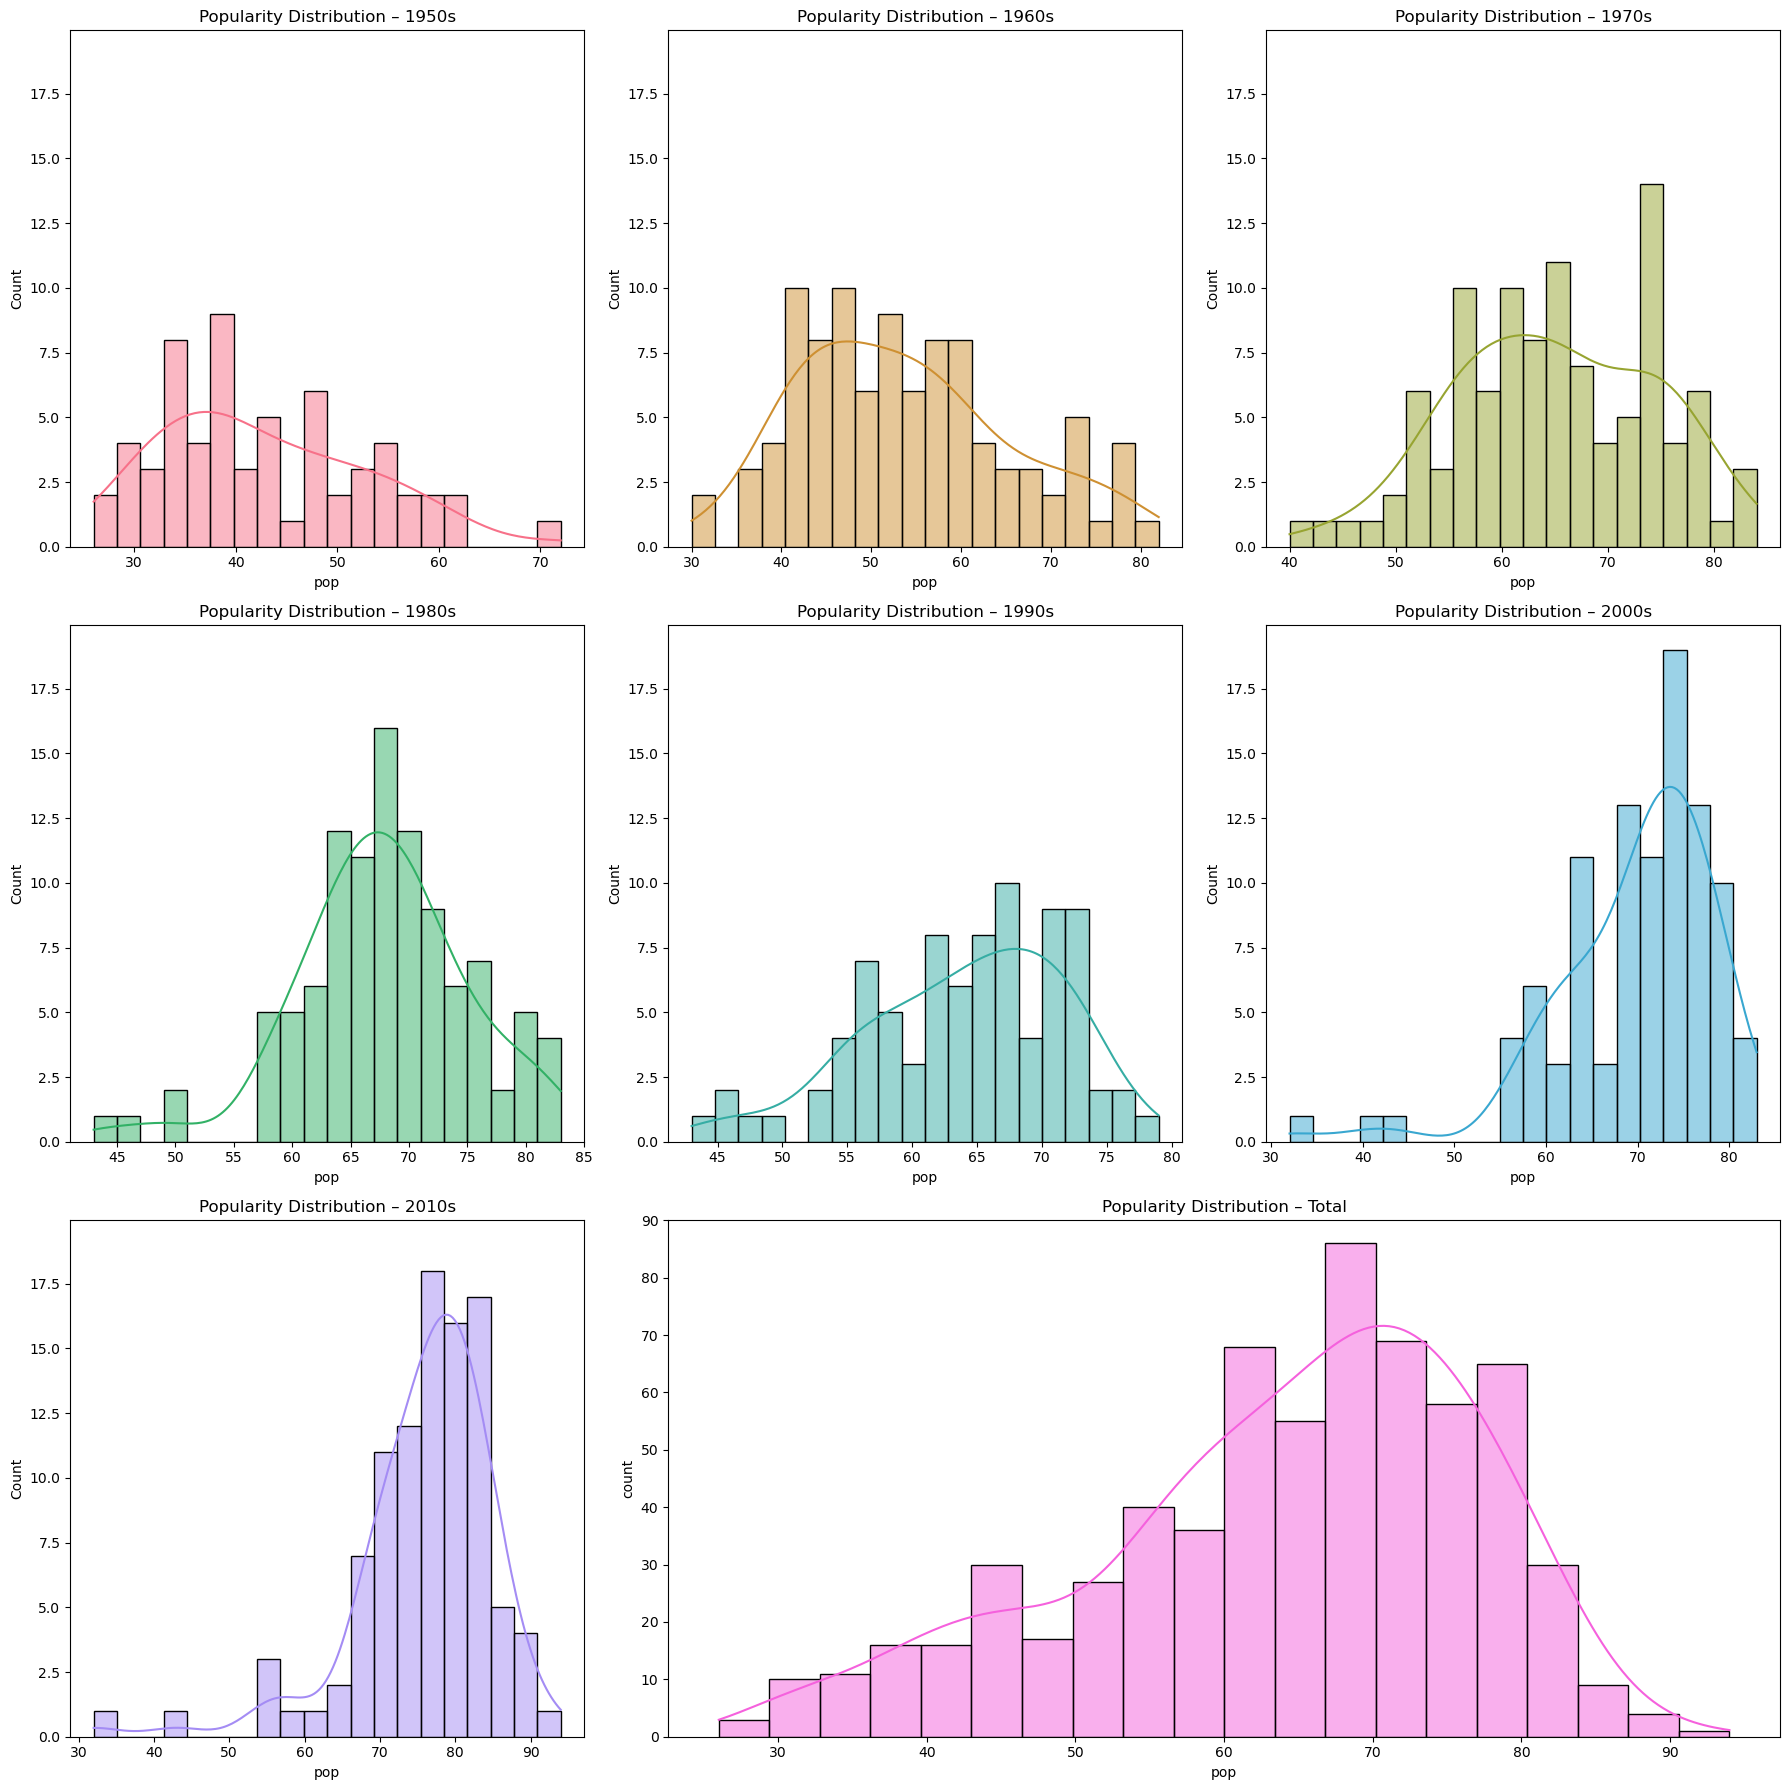

In [14]:
# 2.2 – Set Visual Language

# Decade-specific colours
dec_list = sorted(df_all['decade'].unique())  # Ensure unique sorted decades
palette = sns.color_palette('husl', n_colors = len(dec_list)+1) # +1 for all in pop dist
dec_colours = {int(decade): palette[i] for i, decade in enumerate(dec_list)}

# 2.3 – Target Feature Distribution

# Number of subplots
num_plt = len(decades) + 1  # +1 to include df_all as last subplot
cols = 3  # grid width
rows = -(-num_plt // cols)  # calculate required rows (ceiling division)

# Create figure and GridSpec (no extra-wide columns initially)
fig = plt.figure(figsize = (18,6 * rows))
gs = gridspec.GridSpec(rows, cols, figure = fig)

axes = []  # store subplot axes

# Track max y-limit for normalisation across decades
max_y = 0  

# Loop through decade-specific data
for i, decade in enumerate(decades):
    row, col = divmod(i, cols)  # subplot position
    ax = fig.add_subplot(gs[row, col])  # subplot placement
    axes.append(ax)

    df = globals()[f'df_{decade}']  # get df
    sns.histplot(df['pop'], bins = 20, kde = True, ax = ax, color = palette[i])  
    ax.set_title(f'Popularity Distribution – {decade}s')

    # Track max y-value for normalization
    max_y = max(max_y, ax.get_ylim()[1])

# Apply same y-limit to all decade subplots
for ax in axes:
    ax.set_ylim(0, max_y)

# Total Plot – double-wide to stand-out
last_row = (num_plt - 1) // cols  # find correct plot row
ax_all = fig.add_subplot(gs[last_row, cols - 2:])  # double-wide subplot

sns.histplot(df_all['pop'], bins = 20, kde = True, ax = ax_all, color = palette[-1])
ax_all.set_title('Popularity Distribution – Total')

# Assign unique y-limit for df_all plot
ax_all.set_ylim(0, 90)

# Show last subplot y-ticks (different from others)
ax_all.set_ylabel('count')  
ax_all.yaxis.set_major_locator(plt.MaxNLocator(integer = True))  # ensure integer y-ticks

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

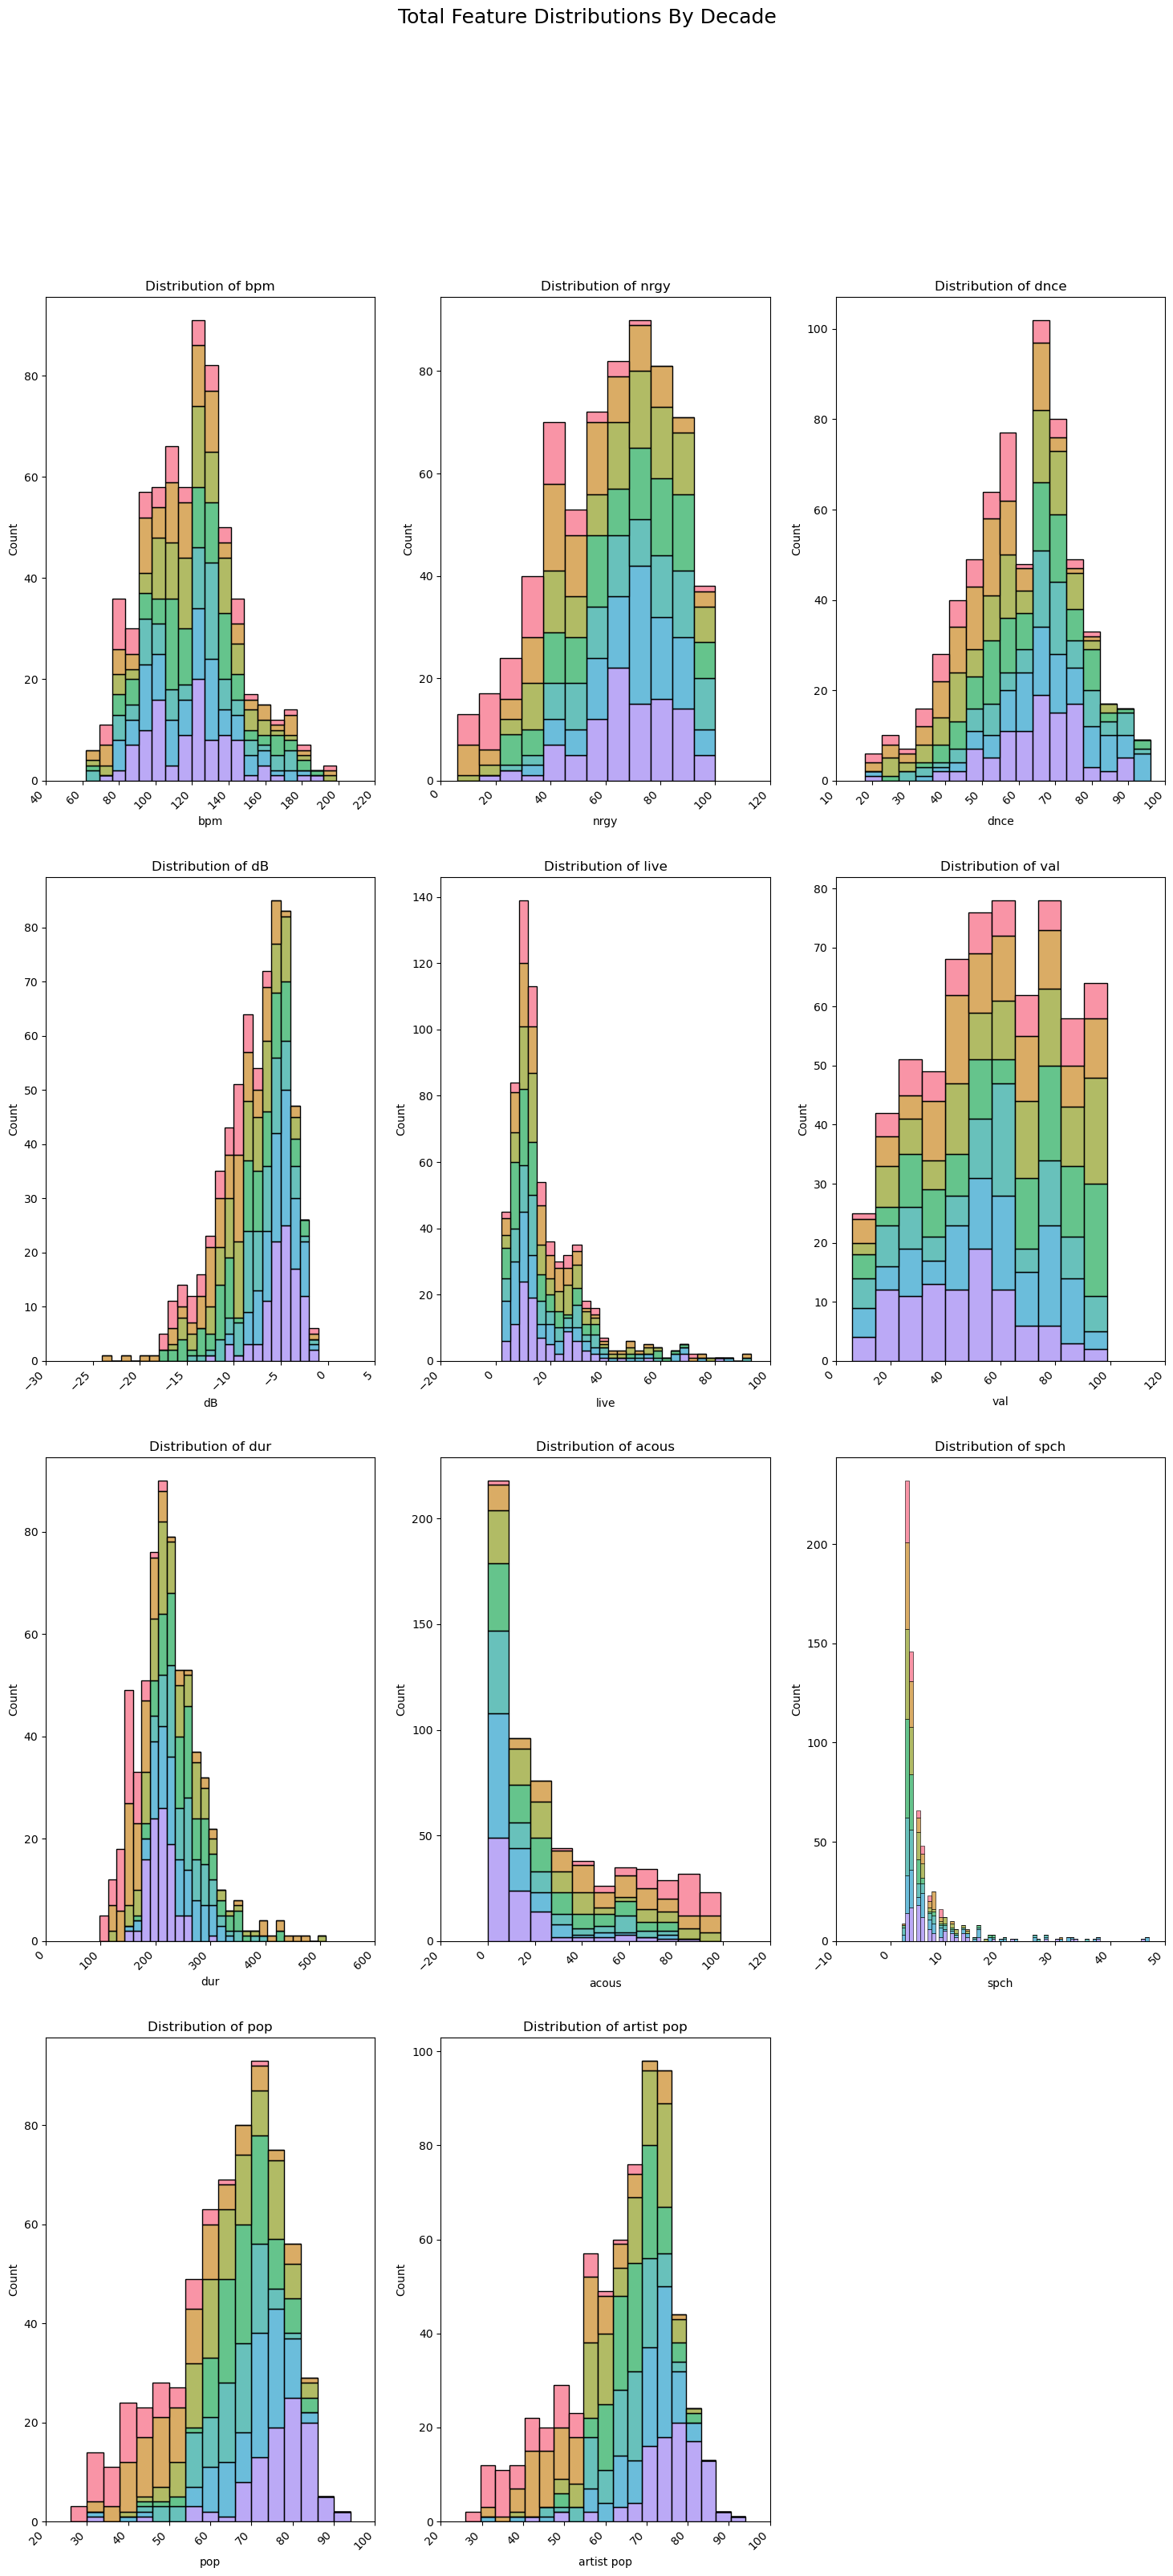

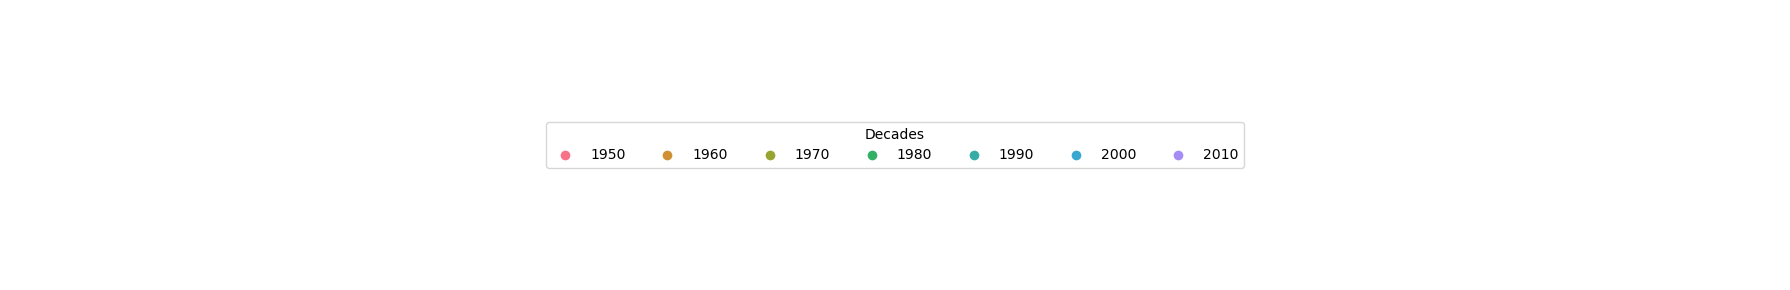

In [15]:
# 2.3 – Distribution of Other Featurss

# Excluded columns
ex_cols = ['top genre', 'number', 'title', 'artist', 'year', 'decade', 'collab', 're-release']
feature_cols = [col for col in df_all.columns if col not in ex_cols]

# Subplot grid set-up
num_features = len(feature_cols)
cols = 3  # Grid columns
rows = -(-num_features // cols) # calculate rows (ceiling division)

fig, axes = plt.subplots(rows, cols, figsize = (18,9 * rows)) # taller plots
fig.suptitle(f'Total Feature Distributions By Decade', fontsize = 18)

axes = axes.flatten()

# Plot df_all distributions
for i, feature in enumerate(feature_cols):
    ax = axes[i]
    
    # Stacked bar-style histogram for decade comparisons
    sns.histplot(
        data = df_all,
        x = feature,
        hue = 'decade',  # colour bars by decade
        multiple = 'stack',  # stack bars for different decades
        palette = dec_colours,
        ax = ax,
        alpha = 0.75,
        legend = False
    )
    
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    
    # x-ticks adjustments
    ax.tick_params(axis = 'x', rotation = 45) # rotation
    ax.set_xticks(ax.get_xticks()) # set tick positions (avoids warning)
    ax.set_xticklabels(ax.get_xticklabels(), ha = 'right')  # alignments

# Create seperate legend
fig_legend, ax_legend = plt.subplots(figsize = (18,3))  # plot just for legend

handles = [plt.Line2D([0], [0], marker = 'o', color = 'w', markersize = 8, markerfacecolor = col) for col in dec_colours.values()]

labels = list(dec_colours.keys())
ax_legend.legend(handles, labels, title = 'Decades', loc = 'center', ncol = len(labels))
ax_legend.axis('off')  # turn of axes for legend plot

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.show(fig_legend)

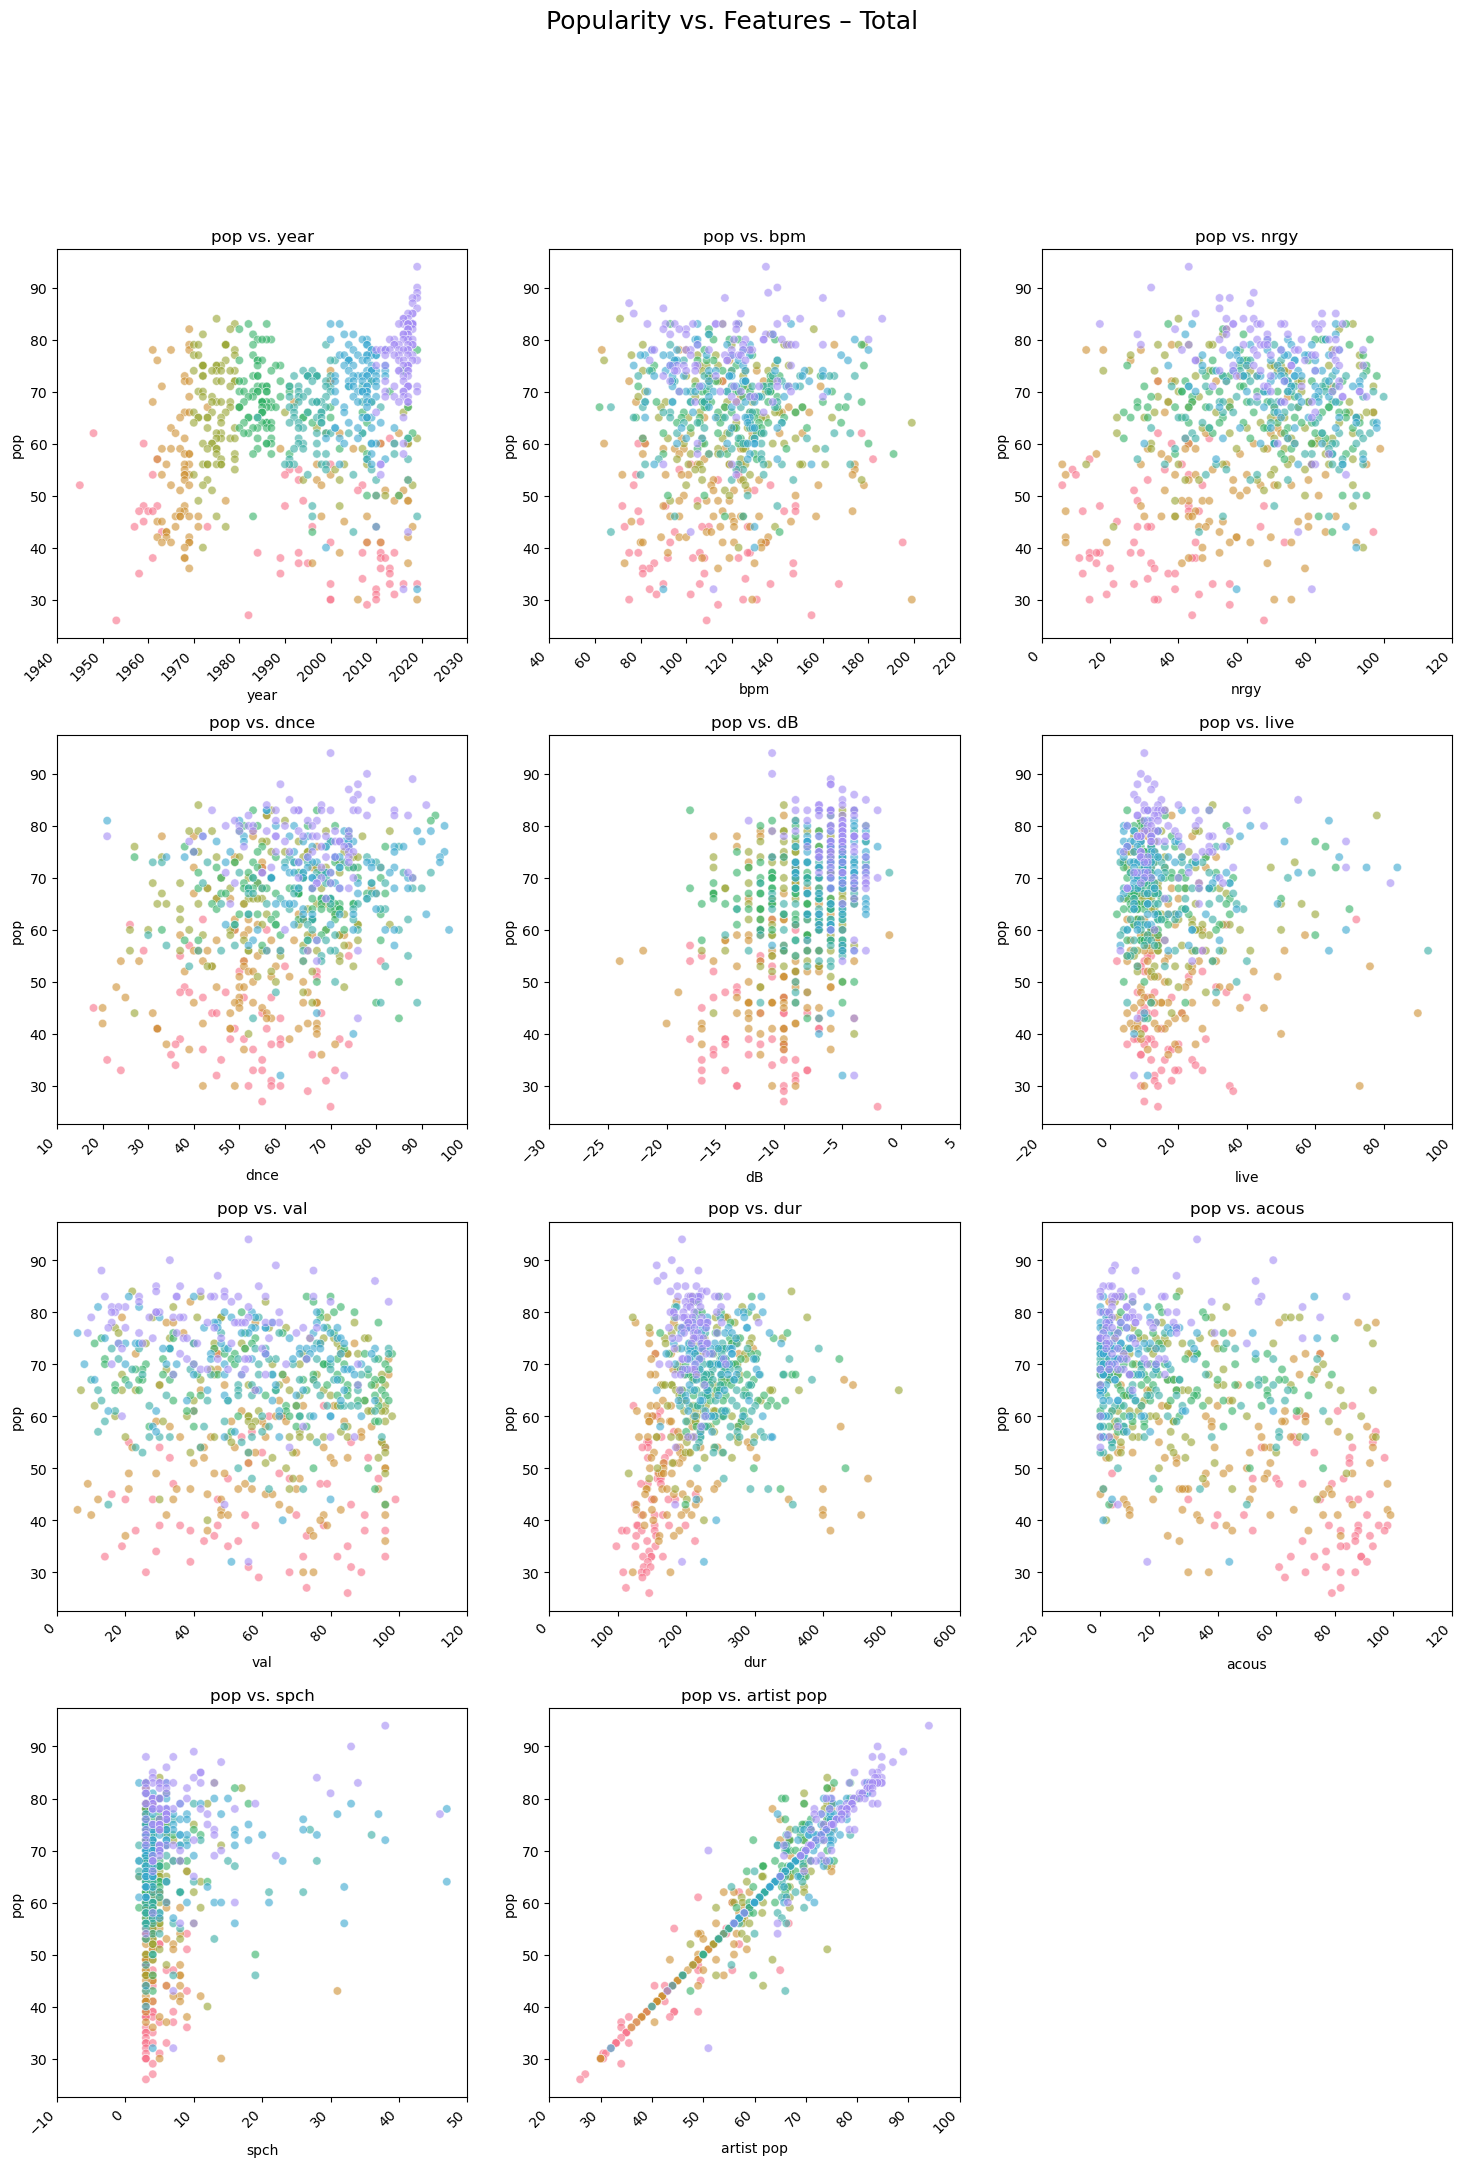

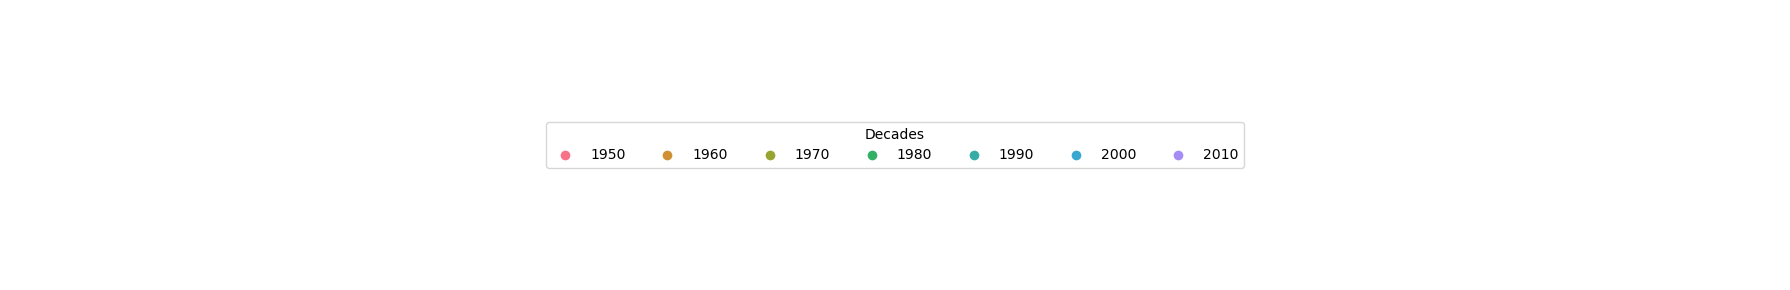

In [16]:
# 2.4 – Plot Features vs. Pop

# Set features to plot
ex_cols = ['top genre', 'pop', 'number', 'title', 'artist', 'decade', 're-release', 'collab'] # excluded
feature_cols = [col for col in df_all.columns if col not in ex_cols] # get all other columns

# Set up plots
num_features = len(feature_cols)  # number of plots
cols = 3  # grid columns
rows = -(-num_features // cols)  # calculate rows

fig, axes = plt.subplots(rows, cols, figsize = (18,6 * rows))
fig.suptitle(f'Popularity vs. Features – Total', fontsize = 18)

axes = axes.flatten()

# Plot df_all data
for i, feature in enumerate(feature_cols):
    ax = axes[i]
    sns.scatterplot(data = df_all, x = feature, y = 'pop', hue = 'decade', ax = ax, alpha = 0.6, palette = dec_colours, legend = False)
    ax.set_title(f'pop vs. {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('pop')
    
    # x-ticks adjustments
    ax.tick_params(axis = 'x', rotation = 45) # rotation
    ax.set_xticks(ax.get_xticks()) # set tick positions (avoids warning)
    ax.set_xticklabels(ax.get_xticklabels(), ha = 'right')  # alignment

# Add some extra space to stop x-tick cut-off
plt.subplots_adjust(hspace = 0.25)

# Create seperate legend (avoids repetition + small plots, so gets in the way)
fig_legend, ax_legend = plt.subplots(figsize = (18,3))  # plot just for legend

handles = [plt.Line2D([0], [0], marker = 'o', color = 'w', markersize = 8, markerfacecolor = col) for col in dec_colours.values()]

labels = list(dec_colours.keys())
ax_legend.legend(handles, labels, title = 'Decades', loc = 'center', ncol = len(labels))
ax_legend.axis('off')  # turn of axes for legend plot

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.show(fig_legend)

In [17]:
# 2.5 – Plot Features with (semeingly) Linear Relationships

def pltLoop(df, decades, fx, fy):
    """
    Parameters:
        df – single dataframe containing all decades
        decades – list of decades to filter from df
        fx & fy – features (cols) for x & y axis

    Output: grid of subplots comparing indivated columns for each decade
    """
    num_dfs = len(decades)  # number of plots
    colours = sns.color_palette('husl', num_dfs)
    cols = 3  # grid columns
    rows = -(-num_dfs // cols)  # calculate rows

    fig, axes = plt.subplots(rows, cols, figsize = (36,6 * rows))
    fig.suptitle(f'{fx} vs. {fy} – by decade', fontsize=18)

    # Ensure axes is iterable
    axes = np.ravel(axes)

    for i, (decade, colour) in enumerate(zip(decades, colours)):
        df_decade = df[df['decade'] == decade]  # filter df by decade
        
        if not df_decade.empty and fx in df_decade.columns and fy in df_decade.columns:
            axes[i].scatter(df_decade[fx], df_decade[fy], color = colour, alpha = 0.6)
            axes[i].set_title(f'{decade}s', fontsize = 14)
            axes[i].set_xlabel(fx)
            axes[i].set_ylabel(fy)
            
            # x-ticks adjustments
            axes[i].tick_params(axis = 'x', rotation = 45) # rotation
            axes[i].set_xticks(axes[i].get_xticks()) # set tick positions (avoids warning)
            axes[i].set_xticklabels(axes[i].get_xticklabels(), ha = 'right')  # alignment

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect = [0, 0, 1, 0.96])  # adjust layout to fit the suptitle
    plt.show()

# Apply function
#pltLoop(df_all, sorted(df_all['decade'].unique()), 'top genre', 'pop') # top genre
#pltLoop(df_all, sorted(df_all['decade'].unique()), 'artist', 'pop') # artist

Only Consistent Artists:


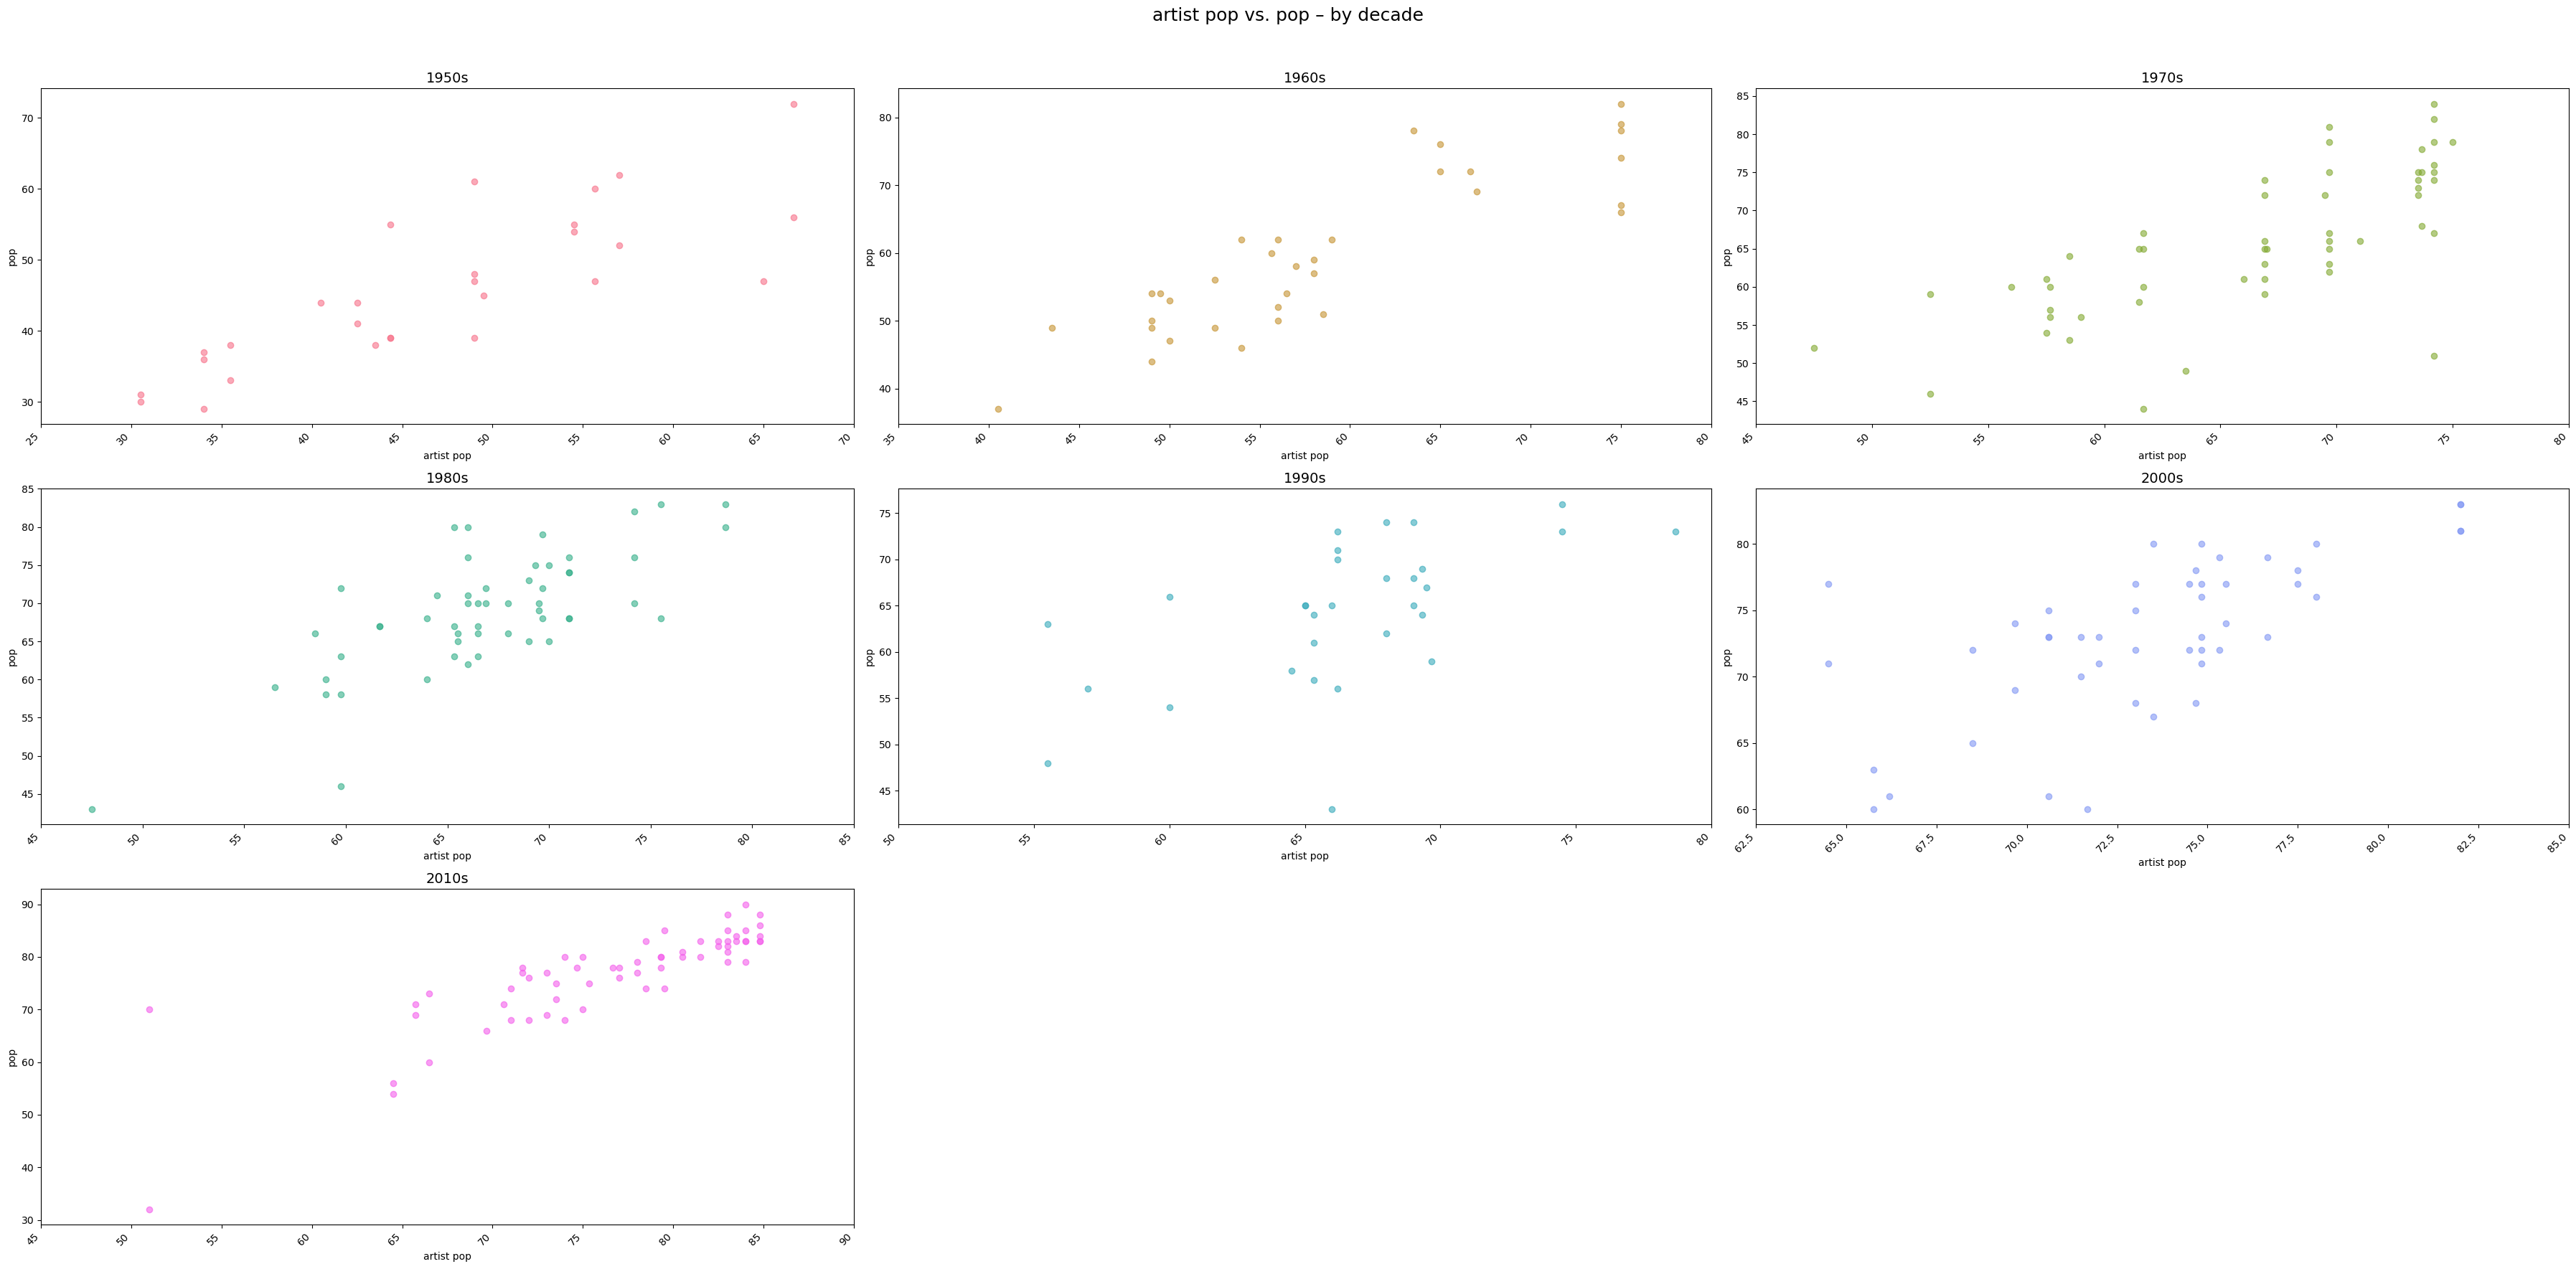

In [18]:
# 2.5.1 – Further Linear Relationships

# Artist Pop – seperate concistent and one-hit wonder artists
df_ohw = df_all.groupby('artist').filter(lambda x: len(x) == 1) # only one-hit wonders
df_nohw = df_all.groupby('artist').filter(lambda x: len(x) > 1) # no one-hit wonders

print('Only Consistent Artists:')
pltLoop(df_nohw, sorted(df_nohw['decade'].unique()), 'artist pop', 'pop')
#print('Only One-Hit Wonders:')
#pltLoop(df_ohw, sorted(df_ohw['decade'].unique()), 'artist pop', 'pop')

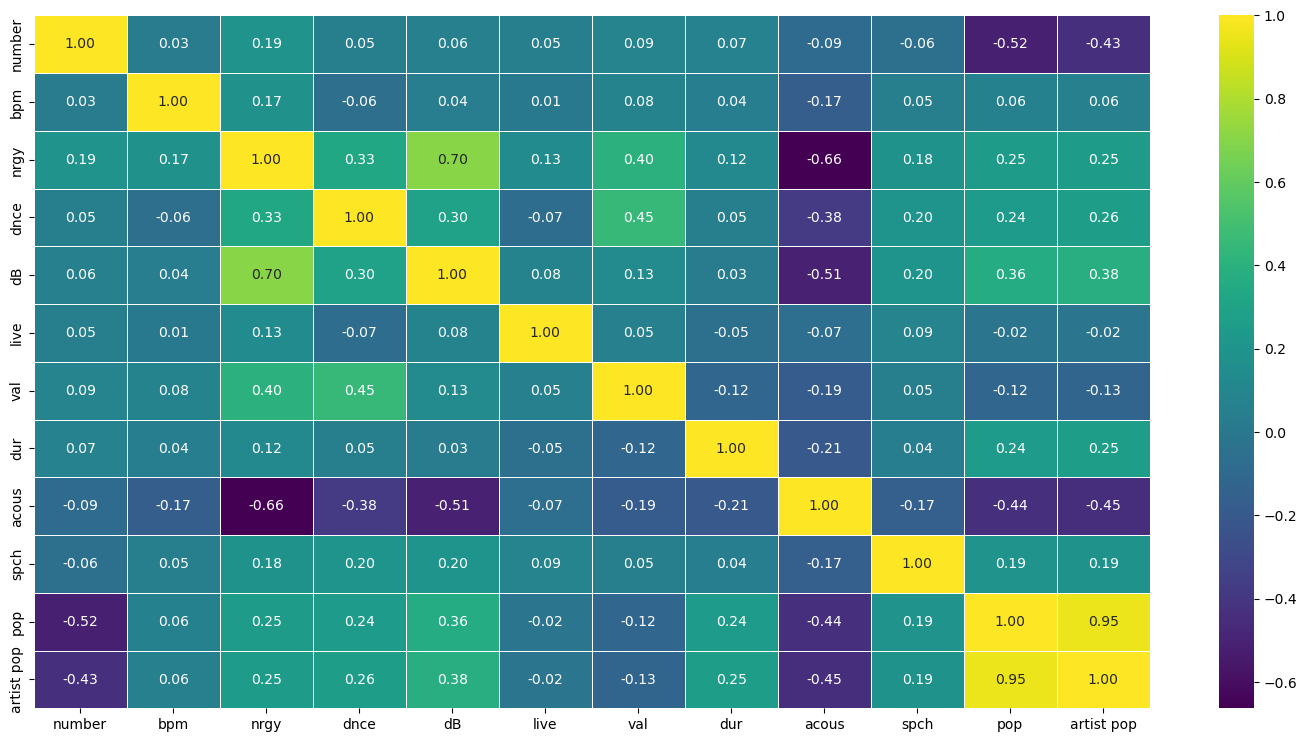

In [19]:
cat_cols = ['title', 'artist', 'top genre', 'year', 'decade', 're-release']
num_cols = ['number', 'bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch', 'artist pop']
target = ['pop']

# 2.6 – Numeric Feature Correlations
df_num = df_all.drop(columns = cat_cols)
corr_matrix = df_num.corr()

# Corr Heatmap
fig, ax = plt.subplots(figsize = (18, 9))
sns.heatmap(corr_matrix, annot = True, cmap = 'viridis', fmt = '.2f', linewidths = 0.5, ax = ax) # viridis handles neg correlations better than coolwarm

plt.show()

In [20]:
# 2.7 – Categorical Features ANOVA

# Decade
anova_dec = stats.f_oneway( *[df_all[df_all['decade'] == decade]['pop'] for decade in dec_list])
print(f'Decade p-value: {anova_dec.pvalue}\n')

# Re-release
anova_rr = stats.f_oneway(
    df_all[df_all['re-release'] == 'yes']['pop'],
    df_all[df_all['re-release'] == 'no']['pop']
)
print(f'Re-release p-value: {anova_rr.pvalue}\n')

# Artist
art_list = df_all['artist'].unique()
anova_art = stats.f_oneway( *[df_all[df_all['artist'] == artist]['pop'] for artist in art_list])
print(f'Artist p-value: {anova_art.pvalue}\n')

Decade p-value: 2.638756346663081e-96

Re-release p-value: 9.19291407386138e-35

Artist p-value: 4.968968548579175e-28



In [21]:
# 2.8 – VIF – Check Multicolinearity

X = df_all[num_cols]
X = add_constant(X)  # add intercept term

# Compute VIF for each feature
vif_res = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Print any significant multicolinearities
print(vif_res.loc[vif_res['VIF'] > 5, 'Feature'])

0    const
Name: Feature, dtype: object


### 3 – Define Core Modelling Functions

Given that the list of identified significant variables is quite large, the decision was made to pursure an iterative model that can loop through all combinations of variables. This idea was further expaned to allow for a simple input in the function to dictate which model is used, rather than having to set up each model seperately.

The final result is 5 functions, with the user calling on 3 of them:
- fCombos ('feature combinations'): loops through all combinations of numerical & categorical features
  - prePro ('pre-processing'): encodes categorical variables, scales numerical variables, and splits data into training & testing sets
  - regModel ('regression model'): runs the user-selected regression model. An older version was able to run multiple models from one call of the function, but this caused issues with hyperparameter tuning & was counter to the notebook's workflow
- modelTuning: begins an Optuna study to tune hyperparameters (steps of 50 for expediency) & applies the optimisations. Also runs Recursive Feature Elimination with Cross-Validation (RFECV) to iteratively remove less-important features.
- modelReTune: Allows for a second optimisation pass & outputs the variables needed for easy output of model performance

In [24]:
# 3.1 – Pre-Processing
def prePro(df, cat_cols, num_cols, target, test_size = 0.2):
    """
    Prep-rocesses dataframe; encoding categorical variables & scaling numerical ones, and
    splits into train & test sets

    Returns:
    X_train, X_test, y_train, y_test as tuple
        (only need to assign single variable when using function)
    """
    # Drop unused columns
    drop_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in (cat_cols + num_cols + [target])]
    df = df.drop(columns = drop_cols).copy()

    # Handle empty feature cases
    if not num_cols and not cat_cols:
        print('Feature Lists Empty')
        return None
    
    # NOTE: Seperated out to handle cases of only cat & only num features
    
    transformers = []

     # Scale numerical features
    if num_cols:
        transformers.append(('num', StandardScaler(), num_cols))

    # Encode categorical features (if present)
    if cat_cols:
        transformers.append(('cat', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), cat_cols))
    
    # Set preprocessor using above
    preprocessor = ColumnTransformer(transformers = transformers)
    
    # Apply transformations
    X = preprocessor.fit_transform(df)

    # Create df of independent variables
    num_features = num_cols if num_cols else []
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols) if cat_cols else []
    feature_names = np.concatenate([num_features, cat_features])
    
    # Set output as df
    X = pd.DataFrame(X, columns = feature_names, index = df.index)

    # Make sure col names are str
    X.columns = X.columns.astype(str)
    
    # Target variable
    y = df[target]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 27)

    return X_train, X_test, y_train, y_test # data_splits

In [25]:
# 3.2 – Apply Model
def regModel(data_splits, model_name):
    """
    Trains and evaluates regression models.
    
    Parameters:
    data_splits – tuple of training & testing data from prePro
    models – List of model names to train (default is all models)
        # input must be shorthand in list-form – ['LR']
    
    Returns:
    DataFrame with model performance metrics
    """
    if data_splits is None:
        print('No Input Data')
        return None
    
    # Generate unique identifier – debugging
    unique_id = uuid.uuid4()
    
    # Unpack data_splits tuples
    X_train, X_test, y_train, y_test = data_splits

    # End process if features in data_splits
    if X_train.shape[1] == 0:
        print('No Features in Input')
        return None
    
    # Define available models
    reg_models = {
        'LR': LinearRegression,  # Linear Regression
        'RF': RandomForestRegressor,  # Random Forest
        'GB': GradientBoostingRegressor,  # Gradient Boost
        'SVR': SVR  # Support Vector Regression
    }
    
    if model_name not in reg_models:
        print(f'"{model_name}" is not an available model – stopping')
        return None, None
    
    # Train the model
    model = reg_models[model_name]()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Collect metrics
    results = {
        'Run ID': unique_id,
        'R-squared': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'Model': model
    }
    
    return results, model # dict & model

In [26]:
# 3.3 – Run Feature Combinations
def fCombos(df, cat_cols, num_cols, model_name, target = 'pop', min_cat = 0, min_num = 0, max_combos = 500, r_thresh = 0.5):
    """
    Generates, runs, & evaluates feature combinations for regression
    Randomly samples combinations to run if total amount is too large

    Parameters:
        df – dataframe
        cat_cols – list of categorical features
        num_cols – list of numerical features
        target – target feature
        min_cat – min no. of categorical featues to be included in run
        min_num – min no. of numerical featues to be included in run
        max_combos – max no. of combos to produce in run
        r_thresh – minimum R-squared value needed for results to be retained

    Returns: sorted dict of significant feature combinations
    """

    # Generate all possible cat & num combos
    cat_combos = [combo for i in range(min_cat, len(cat_cols) + 1) for combo in itertools.combinations(cat_cols, i)]
    num_combos = [combo for j in range(min_num, len(num_cols) + 1) for combo in itertools.combinations(num_cols, j)]

    # Produce all pairings
    all_combos = [(cat_subset, num_subset) for cat_subset in cat_combos for num_subset in num_combos if len(cat_subset) + len(num_subset) > 2]  # no. of features must be > 2

    # Randomly sample if too many combinations
    if len(all_combos) > max_combos:
        all_combos = random.sample(all_combos, max_combos)

    results_dict = {} # dictionary of regModel results
    top_r2 = float('-inf')
    top_model = None

    # Sequential processing (can't get loky or multiprocessing to work)
    for cat_subset, num_subset in all_combos:
        #print(f'\nCategorical: {cat_subset} | Numerical: {num_subset}')
        
        # Create a unique key for the feature combination
        key_name = f'Cat: {cat_subset} | Num: {num_subset}'
        
        # Pre-process data
        data_splits = prePro(df, list(cat_subset), list(num_subset), target)

        # Run regression
        results, model = regModel(data_splits, model_name)  # reset model for each run – previously caused issues
        
        if results and results['R-squared'] >= r_thresh:
            results_dict[key_name] = results
            if results['R-squared'] > top_r2:
                top_r2 = results['R-squared']
                top_model = model  # store the best trained model


    return results_dict, data_splits, top_model # reg_data

In [27]:
# 3.4 – Hyperparameter Tuning

# Suppress optuna info messages
optuna.logging.set_verbosity(optuna.logging.WARNING)

def modelTuning(model_name, reg_data, n_trials = 50, step = 1, cv_folds = 5):
    """
    Optimise hyperparameters for the selected model using Optuna
    Uses Recursive Feature Elimination with Cross-Validation (RFECV) to select features

    Parameters:
        model_name – model to be tuned ('LR', 'RF', 'GB', 'SVR') (!!!str!!!) 
        reg – initial regression run
        n_trials – number of optuna trials for hyperparameter tuning
        step – number of features to remove per iteration in RFECV
        cv_folds – number of cross-validation folds for RFECV

    Returns:
        best_model – trained model with optimal hyperparameters and feature set
        best_params – best hyperparameters found
        selected_features – list of selected features after RFECV
    """
    results_dict, data_splits, top_model = reg_data
    X_train, X_test, y_train, y_test = data_splits
    
    def objective(trial):
        # Define base model & hyperparameter space
        if model_name == 'LR':
            base_model = LinearRegression()
            params = {}  # No hyperparameters for linear regression
        
        elif model_name == 'RF':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300, step = 50),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
            }
        
        elif model_name == 'GB':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300, step = 50),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log = True),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0)
            }
        
        elif model_name == 'SVR':
            params = {
                'C': trial.suggest_float('C', 0.1, 100, log = True),
                'epsilon': trial.suggest_float('epsilon', 0.01, 1.0),
                'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
                'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
            }
        else:
            raise ValueError('Unsupported Model')

        # Set model parameters
        model = top_model.set_params(**params)

        # RFECV to automatically select features
        selector = RFECV(model, step = step, cv = cv_folds, scoring = 'r2', n_jobs = -1)
        X_train_rfe = selector.fit_transform(X_train, y_train)
        
        # Evaluate model performance with cross-validation
        score = cross_val_score(model, X_train_rfe, y_train, cv = cv_folds, scoring = 'r2').mean()
        return score

    # Optuna optimisation
    study = optuna.create_study(direction = 'maximize')
    study.optimize(objective, n_trials = n_trials)

    best_params = study.best_params
    print('\n','-' * 40)
    if model_name == 'LR':
        print('No hyperparameters to tune for Linear Regression\n')
    else:
        print(f'Best Parameters for {model_name}: {best_params}\n')

    # Apply best parameters to top_model
    top_model.set_params(**best_params)

    # Fit RFECV on full dataset with best model
    selector = RFECV(top_model, step = step, cv = cv_folds, scoring = 'r2', n_jobs = -1)
    X_train_rfe = selector.fit_transform(X_train, y_train)
    
    # Train final model on selected features
    top_model.fit(X_train_rfe, y_train)
    
    # Get selected feature names
    selected_features = X_train.columns[selector.support_].tolist()
    print(f'Selected Features: {selected_features}')
    
    return top_model, best_params, selected_features

In [28]:
# 3.5 – Re-tune model
def modelReTune(model_name, m_reg, m_tuned):
    """
    Re-trains & evaluates model

    Parameters:
        model_name – the name of the model (str; e.g. 'RF')
        m_reg – first run of regression model (e.g. lr_reg)
        m_tuned – output of modelTuning (e.g. lr_tuned)

    Returns: Trained model, R-squared, MAE
    """
    # Unpack tuples
    results_dict, data_splits, top_model = m_reg
    X_train, X_test, y_train, y_test = data_splits
    tuned_model, best_params, selected_features = m_tuned
    
    # Re-Trian Model
    if model_name == 'RF':
        model = RandomForestRegressor(**best_params)
    elif model_name == 'GB':
        model = GradientBoostingRegressor(**best_params)
    elif model_name == 'SVR':
        model = SVR(**best_params)
    elif model_name in ['LR', 'skip']: # keep old parameters, re-fit features
        model = tuned_model
    else:
        print('Invalid Model')

    # Transform data using selected fratures
    X_train_rfe = X_train.loc[:, selected_features]
    X_test_rfe = X_test.loc[:, selected_features]
    
    # Re-training
    model.fit(X_train_rfe, y_train)

    # Make predictions
    y_pred = model.predict(X_test_rfe)

    # Evaluate performance
    r2, mae = r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)

    #pred = model.predict(X_test_rfe)

    return model, r2, mae#, pred

### 4 – Linear Regression Model

A fast, simple model that is good for use when buidling the functions and debuggins, due to its speed & relative simplicity. With some work, this model's explanatory power exceeded 50% of a song's popularity score, which is better than expected given how the data visualisations did not show an obvious linear relationship in many places. There weren't even significant non-linear patterns that would've obviously benefitted from polynomial features or log/exp transformations (both were tried).

In [31]:
# 4.0.1 – Key Features
t1_cat, t1_num  = ['decade'], ['dB', 'live', 'spch', 'acous']
t2_cat, t2_num  = ['re-release'], ['dnce', 'dur']
key_cat, key_num = t1_cat + t2_cat, t1_num + t2_num

# 4.0.2 – Target Variable Stats
tv_range = df_all['pop'].max() - df_all['pop'].min()
tv_q1, tv_q3 = df_all['pop'].quantile([0.25, 0.75])
tv_iqr = tv_q3 - tv_q1
tv_std = df_all['pop'].std()

In [32]:
# 4.1 – Run Model
lr_reg = fCombos(df_all, key_cat, key_num, model_name = 'LR')

# 4.2 – Tune Model
lr_tuned = modelTuning('LR', lr_reg)

# 4.3 – Re-Tune Model
lr_model, lr_r2, lr_mae = modelReTune('LR', lr_reg, lr_tuned)

print(f'\nTarget Variable Stats:\n – Range: {tv_range:}\n – IQR: {tv_iqr:}\n – St. Dev: {tv_std:.4f}')
print('-' * 40)
print(f'\nFinal Model Performance:\n – R-squared Score: {lr_r2:.4f}\n – MAE: {lr_mae:.4f}\n')


 ----------------------------------------
No hyperparameters to tune for Linear Regression

Selected Features: ['decade_1950', 'decade_1960', 'decade_1980', 'decade_2000', 'decade_2010', 're-release_no', 're-release_yes']

Target Variable Stats:
 – Range: 68
 – IQR: 18.0
 – St. Dev: 13.1659
----------------------------------------

Final Model Performance:
 – R-squared Score: 0.5169
 – MAE: 6.7910



In [33]:
# 4.4 – Manual Correction – issue with tuning/loop

# Unpack & Re-pack tuple
results_dict, data_splits, top_model = lr_reg # check results_dict
lr_best = max(results_dict, key=lambda k: results_dict[k]['R-squared']) # pull best run
tuned_model, best_params, selected_features = lr_tuned
selected_features = ['dur','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000','decade_2010','re-release_no','re-release_yes']
lr_tuned_cust = tuned_model, best_params, selected_features

gb2_model, gb2_r2, gb2_mae = modelReTune('LR', lr_reg, lr_tuned_cust)
print(f'\nTarget Variable Stats:\n – Range: {tv_range:}\n – IQR: {tv_iqr:}\n – St. Dev: {tv_std:.4f}')
print('-' * 40)
print(f'\nFinal Model Performance:\n – R-squared Score: {gb2_r2:.4f}\n – MAE: {gb2_mae:.4f}\n')


Target Variable Stats:
 – Range: 68
 – IQR: 18.0
 – St. Dev: 13.1659
----------------------------------------

Final Model Performance:
 – R-squared Score: 0.5188
 – MAE: 6.7824



### 5 – Gradient Boosting Model

The primary model with the highest explanatory power, although it is not signfiicantly better than linear regression. Gradient Boosting was chosen as its known to be the foundation of highly accurate models, and works well with mid-size datasets (accurate with a lower tendency to overcorrect). The choice of this model is why there is a function for a multi-stage hyperparameter tuning; just ensuring that it can be trained & refined easily.

The prevalence of non-linear relationships in the dataset supports the use of GB, as it captures them very well. This is why the notebook has an iterative loop approach; to see if there's anything that wasn't obvious upon manual inspection during the EDA.

In [36]:
# 5.1 – Run Model
gb_reg = fCombos(df_all, key_cat, key_num, model_name = 'GB')

# 5.2 – Tune Model
gb_tuned = modelTuning('GB', gb_reg)

# 5.3 – Re-Tune Model
gb_model, gb_r2, gb_mae = modelReTune('GB', gb_reg, gb_tuned)

print(f'\nTarget Variable Stats:\n – Range: {tv_range:}\n – IQR: {tv_iqr:}\n – St. Dev: {tv_std:.4f}')
print('-' * 40)
print(f'\nFinal Model Performance:\n – R-squared Score: {gb_r2:.4f}\n – MAE: {gb_mae:.4f}\n')


 ----------------------------------------
Best Parameters for GB: {'n_estimators': 300, 'learning_rate': 0.011042671369117412, 'max_depth': 3, 'subsample': 0.6406492928944559}

Selected Features: ['dB', 'live', 'spch', 'acous', 'dnce', 'dur', 'decade_1950', 'decade_1960', 'decade_1980', 'decade_1990', 'decade_2000', 'decade_2010', 're-release_no', 're-release_yes']

Target Variable Stats:
 – Range: 68
 – IQR: 18.0
 – St. Dev: 13.1659
----------------------------------------

Final Model Performance:
 – R-squared Score: 0.4982
 – MAE: 6.9342



In [78]:
# 5.4 – Manual Correction – issue with tuning/loop

# Unpack & Re-pack tuple
results_dict, data_splits, top_model = gb_reg # check results_dict
gb_best = max(results_dict, key=lambda k: results_dict[k]['R-squared']) # pull best run
tuned_model, best_params, selected_features = gb_tuned
selected_features = ['acous','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000','decade_2010','re-release_no','re-release_yes']
gb_tuned_cust = tuned_model, best_params, selected_features

# Get model, export to csv (highest scoring)
gb2_model, gb2_r2, gb2_mae = modelReTune('GB', gb_reg, gb_tuned_cust)
#gb2_pred = pd.DataFrame(gb2_pred, columns = ['Predicted Popularity']) # inc. gb2_pred as last item before '=' in line above
#gb2_pred.to_csv('predicted_popularity.csv', index = False)

print(f'\nTarget Variable Stats:\n – Range: {tv_range:}\n – IQR: {tv_iqr:}\n – St. Dev: {tv_std:.4f}')
print('-' * 40)
print(f'\nFinal Model Performance:\n – R-squared Score: {gb2_r2:.4f}\n – MAE: {gb2_mae:.4f}\n')


Target Variable Stats:
 – Range: 68
 – IQR: 18.0
 – St. Dev: 13.1659
----------------------------------------

Final Model Performance:
 – R-squared Score: 0.5233
 – MAE: 6.8426



### 6 – Random Forest Model

Added as an extra model due to Gradient Boosting uncerperforming. There may have been something in the data that could have been picked up using RF, but there wasn't, and it is the worst-performing model. It could have been a good option for exploring larger datasets with many categorical featires, as was originally the plan; where sentiment analysis was being ran on song titles, and emotionally-charged words were being included as an encoded feature. However, it grew too large and powered more issues than discoveries.

In [ ]:
# 6.1 – Run Model
rf_reg = fCombos(df_all, key_cat, key_num, model_name = 'RF')

# 6.2 – Tune Model
rf_tuned = modelTuning('RF', rf_reg)

# 6.3 – Re-Tune Model
rf_model, rf_r2, rf_mae = modelReTune('RF', rf_reg, rf_tuned)

print(f'\nTarget Variable Stats:\n – Range: {tv_range:}\n – IQR: {tv_iqr:}\n – St. Dev: {tv_std:.4f}')
print('-' * 40)
print(f'\nFinal Model Performance:\n – R-squared Score: {rf_r2:.4f}\n – MAE: {rf_mae:.4f}\n')

In [ ]:
# 6.4 – Manual Correction – issue with tuning/loop

# Unpack & Re-pack tuples
results_dict, data_splits, top_model = rf_reg # check results_dict
lr_best = max(results_dict, key=lambda k: results_dict[k]['R-squared']) # pull best run
tuned_model, best_params, selected_features = rf_tuned
selected_features = ['dB','spch','dur','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000','decade_2010','re-release_no','re-release_yes']
rf_tuned_cust = tuned_model, best_params, selected_features

rf2_model, rf2_r2, rf2_mae = modelReTune('RF', rf_reg, rf_tuned_cust)
print(f'\nTarget Variable Stats:\n – Range: {tv_range:}\n – IQR: {tv_iqr:}\n – St. Dev: {tv_std:.4f}')
print('-' * 40)
print(f'\nFinal Model Performance:\n – R-squared Score: {rf2_r2:.4f}\n – MAE: {rf2_mae:.4f}\n')

### 7 – Conclusion & Limitations

All included models have extemely mediocre explanatory power, and this may be largely due to a problem that exists somewhere in the 'iterative loop'. The model with the top R-squared score is supposed to be selected and passed through to the next function, but it is not, and the last model in the loop is seemingly passed through instead.

This was not properly understood until after a signficant amount of time was spent tuning certain aspects of the models. Manually pulling the top result helps but there is likely soe further explanatory power not being captured.